In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 데이터 경로 설정
data_path = "./dataset/train/digital_img"  # 여기에는 데이터셋의 경로를 입력하세요.

# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rescale=1./255,        # 이미지 값을 0과 1 사이로 조정
    shear_range=0.2,       # 전단변환을 적용
    zoom_range=0.2,        # 랜덤으로 이미지를 확대 또는 축소
    horizontal_flip=True,  # 랜덤으로 이미지를 수평으로 뒤집기
    validation_split=.2   # validation 데이터의 비율 지정
)

# 데이터셋 로딩 및 전처리
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),  # ResNet50의 기본 입력 크기에 맞춤
    batch_size=32,
    class_mode='categorical',  # 다중 클래스 분류
    shuffle=True,
    subset='training'           # 학습 데이터의 비율 지정
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),  # validation 데이터의 크기는 훈련과 동일하게 설정
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# ResNet50 모델 불러오기 (include_top=False로 변경)
base_model = ResNet50(weights='imagenet', include_top=False)

# 새로운 분류 층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)  # 클래스 수에 맞게 조정

# 새로운 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 미리 학습된 층은 동결 (Fine-tuning을 위한 기본 설정)
for layer in base_model.layers:
    layer.trainable = False
    
# 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

base_model.trainable = True
for i in base_model.layers[:130]:
    i.trainable = False
# Fine-tuning 진행
history = model.fit(
    train_generator,
    epochs=13,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

Found 677 images belonging to 8 classes.
Found 165 images belonging to 8 classes.
Epoch 1/13
22/22 [==============================] - 51s 2s/step - loss: 2.1196 - accuracy: 0.2541 - val_loss: 1.9200 - val_accuracy: 0.3030
Epoch 2/13
22/22 [==============================] - 42s 2s/step - loss: 1.7497 - accuracy: 0.3885 - val_loss: 1.7750 - val_accuracy: 0.2182
Epoch 3/13
22/22 [==============================] - 45s 2s/step - loss: 1.5451 - accuracy: 0.4919 - val_loss: 1.4181 - val_accuracy: 0.6545
Epoch 4/13
22/22 [==============================] - 47s 2s/step - loss: 1.3616 - accuracy: 0.5436 - val_loss: 1.3993 - val_accuracy: 0.4061
Epoch 5/13
22/22 [==============================] - 46s 2s/step - loss: 1.1967 - accuracy: 0.6499 - val_loss: 1.2177 - val_accuracy: 0.6848
Epoch 6/13
22/22 [==============================] - 46s 2s/step - loss: 1.0386 - accuracy: 0.7194 - val_loss: 1.0985 - val_accuracy: 0.6424
Epoch 7/13
22/22 [==============================] - 42s 2s/step - loss: 0.9525

In [2]:
num_classes = len(train_generator.class_indices)
print("클래스의 수:", num_classes)

# 각 클래스별 이미지 수 확인
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)}
print("각 클래스별 이미지 수:", class_counts)

# 전체 이미지 수 확인
total_images = sum(class_counts.values())
print("전체 이미지 수:", total_images)

클래스의 수: 8
각 클래스별 이미지 수: {'d1_1': 133, 'd1_2': 111, 'd1_3': 108, 'db_1': 106, 'db_2': 109, 'db_3': 113, 'etc': 22, 'foun': 140}
전체 이미지 수: 842


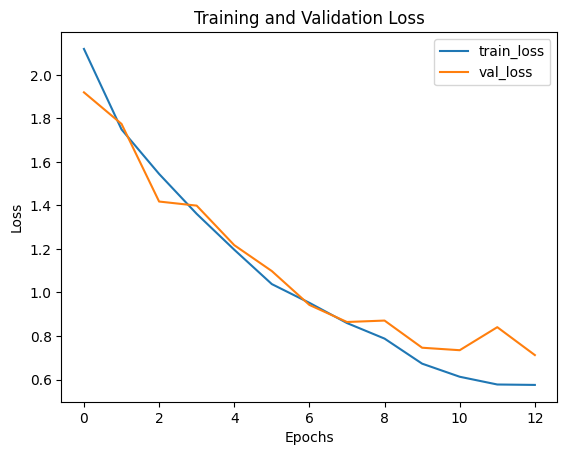

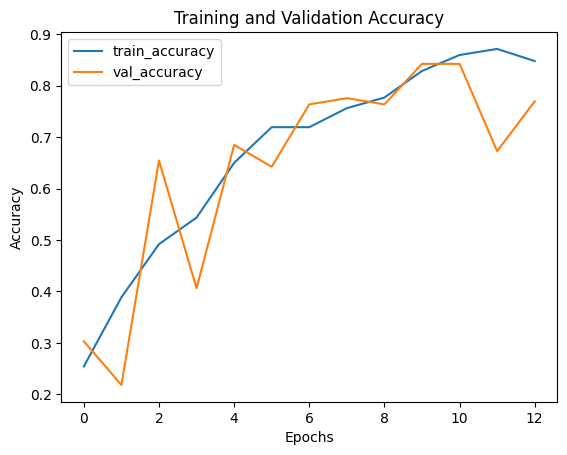

In [3]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
import os

path = "dataset/train/digital_img"

class_name = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

images = "./pred"

image_name = [f for f in os.listdir(images)]
image_name

['d1_1.jpg',
 'd1_1_2.jpg',
 'd1_1_3.jpg',
 'd1_1_4.jpg',
 'd1_2.jpg',
 'd1_2_2.jpg',
 'd1_3.jpg',
 'd1_3_2.jpg',
 'db125.jpg',
 'db1252.jpg',
 'db_1.jpg',
 'db_2.jpg',
 'db_3.jpg',
 'foun.jpg',
 'foun2.jpg',
 'foun3.png']

In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image

l = len(image_name)
c = 0

for i in image_name:
# 예측할 이미지 로드 및 전처리
    image_path = f"./pred/{i}"  # 예측하고자 하는 이미지의 경로를 입력하세요.
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # 이미지를 [0, 1] 범위로 정규화
    # 모델에 입력 이미지 전달하여 예측 수행
    predictions = model.predict(img_array)

    # 예측 결과 출력
    predicted_class = np.argmax(predictions)

    predicted_label = class_name[predicted_class]

    print(np.max(predictions))
    print(i , predicted_label)
    if i.find(predicted_label) != -1:
        c += 1
print(f"{(c / l)*100}%")

1/1 [==============================] - 0s 79ms/step
0.82770836
d1_1.jpg d1_1
1/1 [==============================] - 0s 70ms/step
0.6788397
d1_1_2.jpg d1_1
1/1 [==============================] - 0s 71ms/step
0.7574276
d1_1_3.jpg d1_1
1/1 [==============================] - 0s 71ms/step
0.9217574
d1_1_4.jpg d1_1
1/1 [==============================] - 0s 79ms/step
0.7662424
d1_2.jpg foun
1/1 [==============================] - 0s 71ms/step
0.84010214
d1_2_2.jpg d1_2
1/1 [==============================] - 0s 80ms/step
0.34915325
d1_3.jpg d1_2
1/1 [==============================] - 0s 75ms/step
0.7899632
d1_3_2.jpg d1_3
1/1 [==============================] - 0s 78ms/step
0.7928102
db125.jpg db_1
1/1 [==============================] - 0s 79ms/step
0.63176274
db1252.jpg d1_3
1/1 [==============================] - 0s 74ms/step
0.6591413
db_1.jpg db_1
1/1 [==============================] - 0s 67ms/step
0.71733844
db_2.jpg db_2
1/1 [==============================] - 0s 68ms/step
0.9088401
db_3.jpg

In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image

# 예측할 이미지 로드 및 전처리
image_path = "pred/d1_3_2.jpg"  # 예측하고자 하는 이미지의 경로를 입력하세요.
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # 이미지를 [0, 1] 범위로 정규화
# 모델에 입력 이미지 전달하여 예측 수행
predictions = model.predict(img_array)

# 예측 결과 출력
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(np.max(predictions))
print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 80ms/step
0.30377662
Predicted label: d1_1


In [6]:
model.save("kumoh2.h5")

In [8]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
loaded_model = load_model("kumoh2.h5")

In [32]:
import numpy as np
from tensorflow.keras.preprocessing import image

# 예측할 이미지 로드 및 전처리
image_path = "pred/pre1.jpg"  # 예측하고자 하는 이미지의 경로를 입력하세요.
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # 이미지를 [0, 1] 범위로 정규화
# 모델에 입력 이미지 전달하여 예측 수행
predictions = loaded_model.predict(img_array)

# 예측 결과 출력
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(np.max(predictions))
print("Predicted label:", predicted_label)

1/1 [==============================] - 1s 856ms/step
0.5181303
Predicted label: d1_3
